In [16]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import random
from mpmath import mp
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm 
from copy import copy

In [17]:
class envir():
    def __init__(self):
        self.phi = 4
        self.S = np.array([1,1,1,1])
    
    def step(self,task,s,jobsize):
        s_old = s[task]
        reward = 0
        
        if(s_old==jobsize[task] or s_old==0):
            s_new = 0
        else:
            s_new = s_old+1
        
        if(s_old==0):
            reward = -1000
        elif(s_old!=0 and s_new!=0):
            reward = 0
        else:
            reward = 1

        new_state = [0,0,0,0]
        for i in range(4):
            if i==task:
                new_state[i] = s_new
            else:
                new_state[i] = s[i]
        
        return new_state,reward
    
    def getjob(self):
        num_samples = 4
        discretized_values = np.arange(1, 11, 0.1)
        # Sample from log-normal distribution and clip
        sampled_values_clipped = np.clip(np.random.uniform(1, 10, num_samples), 1, 10)

        # Digitize the clipped values
        sampled_values = discretized_values[np.digitize(sampled_values_clipped, discretized_values)]
        j = [0]*len(sampled_values)
        #print(sampled_values)
        for i in range(len(sampled_values)):
            j[i] = math.floor((sampled_values[i]-1)/(0.1) + 1)        
        return j


In [18]:
env = envir()
print(env.getjob())

[81, 84, 80, 20]


In [19]:
class Agent():
    def __init__(self,alpha,gamma):
        self.Q_values = np.zeros((101,101))
        self.phi = 4
        self.S = np.array([6,6,6,6])
        self.alpha = alpha
        self.gamma = gamma
def select_task(s,M):
        k = []
        for i in range(4):
            k.append(M[s[i]])
        #print(k)
        max_index = np.argmax(k)  # Get the index of the maximum value
        return max_index
    
def choose_arm(s,W,epsilon):
        wl= []
        p = np.array([0,0,0,0])
        if np.random.random() < epsilon:
            for i in range(len(p)):
                #if s[i]!=0:
                    wl.append(i)
            arm_to_pull = np.random.choice(wl,1)[0]
            return arm_to_pull
        else:
            p2 = {}
            for i in range(len(p)):
                #if s[i]!=0:
                    p2[i] = W[s[i]]
            max_key = max(p2, key=p2.get)
            return max_key
    

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:35<00:00, 10.87it/s]


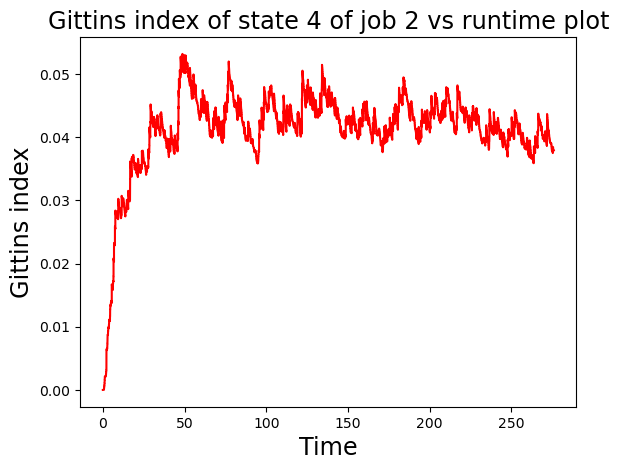

[-1.00000000e+05  2.08635274e+00  2.82891142e+00  2.26322108e+00
  2.68384113e+00  2.72319461e+00  2.62799756e+00  3.27390886e+00
  2.99622009e+00  2.79798876e+00  3.00439846e+00  3.24099399e+00
  3.54374419e+00  3.30166241e+00  3.30192085e+00  3.41319624e+00
  3.35010021e+00  3.48577432e+00  4.07983862e+00  4.12791768e+00
  4.42065781e+00  3.43434260e+00  3.95560462e+00  3.59758907e+00
  3.42236123e+00  3.68530283e+00  3.29060849e+00  3.62359897e+00
  4.26199665e+00  3.74919993e+00  4.04260296e+00  4.54190173e+00
  4.10658717e+00  3.84450837e+00  3.79335179e+00  4.02070419e+00
  4.05494432e+00  4.25244243e+00  4.19025847e+00  4.60155113e+00
  4.90047929e+00  5.32761386e+00  4.88206824e+00  4.88450807e+00
  4.99508537e+00  4.87465441e+00  4.54776905e+00  4.53344254e+00
  4.53495585e+00  4.91129759e+00  4.91666888e+00  5.17749956e+00
  5.26074405e+00  6.00740304e+00  6.23360266e+00  6.34663691e+00
  6.45766422e+00  6.26113017e+00  6.63441562e+00  6.62397388e+00
  6.62676697e+00  6.87529

In [21]:
class game():
    start_time = time.time()
    M = np.zeros((101))
    '''for i in range(100):
        for j in range(9):
            M[i][j] = 0'''
    c0 = 0
    hist01 = []
    ti = []
    c1 = 0
    m = 0
    Q_values = np.zeros((101,101))
    m1 = 0
    ct = 0
    F = np.zeros((101))
    env = envir()
    trials = 3000
    tries = 0
    agent = Agent(alpha = 0.3,gamma = 0.99)
    for trial_no in tqdm(range(trials)):
        s = np.array([1,1,1,1])
        #Calculating Q values over state space for a given arm for the given M vector through Q learning
        #for step in range(2):
        #print(tries,trial_no)
        jobsize = env.getjob()
        tries = 0 
        while (s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0):
            tries += 1 
            task = choose_arm(s,M,0.1)
            current_time = time.time()-start_time
            next_state, R = env.step(task,copy(s),jobsize)
            #print(task)
            #print(next_state)
            #print('r',R)
            for k in range(101):
                Q_values[s[task]][k] += agent.alpha*(R+agent.gamma*(max(M[k],copy(Q_values[next_state[task]][k])))-Q_values[s[task]][k])    
            if((trial_no%50)==0):
                agent.alpha = agent.alpha-0.000002
            s= copy(next_state) 

          #Algorithm for stochastic approximation

          #Calculating F
            for i in range(101):
                F[i]= -M[i]+Q_values[i][i]
                #print('F',F[i][task])
                #print('m',M[i][task])
                #print('q',Q_values[i][i][task])
    
          #Print values
            #print("Iteration no",t)
            #print("F",F)

          #Update M
            for i in range(101):
                M[i] = M[i] + 0.6*(F[i])       
            hist01.append(0.01*M[34])
            ti.append(current_time)
        
          #Stopping criteria
          #For M[i]
            '''if(t>=10):
                if(F[0]==0 and (histV0[len(histV0)-1]-histV0[len(histV0)-5]<0.1)):
                    ct=1;
                    m=M[0]   
          #For algorithm
            print(" ")
            histm0.append(M[0])
            histm1.append(M[1])
            if ((np.linalg.norm(F)<.9) or t>=9000) and (t>=2 and np.linalg.norm(V-Vold)<0.1):
                print("Gittin's index for state 0 is",0.2*min(m,(M[0])))
                print("Gittin's index for state 1 is",0.2*(M[1]))
                break'''
    plt.title('Gittins index of state 4 of job 2 vs runtime plot',fontsize='xx-large')
    plt.xlabel('Time', fontsize = 'xx-large')
    plt.ylabel('Gittins index',fontsize = 'xx-large')
    plt.plot(ti,hist01,'-',c='red')
    plt.show()
    print(M)